<a href="https://colab.research.google.com/github/kdanu/Data-Science-Project/blob/main/Movie_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sistem Rekomendasi Film dengan Pendekatan Collaborative Filtering

Tahap pertama yang dilakukan adalah mengimport semua library yang dibutuhkan.

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


Lalu kita download dataset yang dibutuhkan, dan di unzip. berikut link download dataset nya http://files.grouplens.org/datasets/movielens/ml-latest-small.zip  

In [ ]:
!wget 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
!unzip 'ml-latest-small.zip'

--2021-11-25 22:58:53--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   943KB/s    in 1.0s    

2021-11-25 22:58:55 (943 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Dapat dilihat kalau ada 5 file di dalam filw ml-latest-small.zip yang di download tadi. Tetapi file yang akan kita load hanya file ratings.csv dan movies.csv .

In [ ]:
rating = pd.read_csv('ml-latest-small/ratings.csv')
movie= pd.read_csv('ml-latest-small/movies.csv')

In [ ]:
rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Berdasarkan userId yang tidak duplikat ternyata jumlah data rating ada  610 dan berdasarkan movie id yang tidak duplikat ternyata jumlah data movie ada 9742

In [ ]:
print('Jumlah data rating film: ', len(rating.userId.unique()))
print('Jumlah data film: ', len(movie.movieId.unique()))

Jumlah data rating film:  610
Jumlah data film:  9742


selanjutnya kita cek apakah ada missing value di dataset yang kita gunakan, dapat dilihat pada file rating tidak ada missing value.

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


selanjutnya kita cek apakah ada missing value di dataset yang kita gunakan, dapat dilihat pada file movie juga tidak ada missing value sama sekali.

In [ ]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Kita coba cek genre film yang ada, ternyata banyak sekali, bahkan satu film memiliki 2 sampai 3 genre.

In [ ]:
print('Jumlah genre film: ', movie.genres.unique())

Jumlah genre film:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Children|Comedy' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Drama|Thriller'
 'Comedy|Crime' 'Action|Sci-Fi|Thriller' 'Action|Comedy|Horror|Thriller'
 'Comedy|Drama' 'Documentary' 'Action|Crime|Drama|Thriller'
 'Crime|Drama|Romance' 'Action|Adventure|Drama' 'Action|Thriller'
 'Drama|Horror|Thriller' 'Com

Sebelum file rating dan movie di gabungkan, kolom timestamp pada file rating akan dihapus karena kurang relevan

In [ ]:
rating.drop('timestamp', axis = 1, inplace=True)

lalu gabungkan file rating dan movie, lalu simpan di variabel baru bernama user_movie_rating

In [ ]:
user_movie_rating = pd.merge(rating, movie, on = 'movieId', how='left')
user_movie_rating.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Kita cek dataset setelah di merge dan tidak ada missing value

In [ ]:
user_movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


In [ ]:
preparation= user_movie_rating
preparation.sort_values('movieId')

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
81531,517,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
30517,213,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
81082,514,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
30601,214,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
27256,184,193581,4.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,Flint (2017),Drama
27259,184,193587,3.5,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Lalu kita buang data yang duplikat

In [ ]:
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100820,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100821,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100823,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100827,610,163937,3.5,Blair Witch (2016),Horror|Thriller


Setelah itu kita konversi kolom movieId, title, dan genres ke dalam bentuk list

In [ ]:
movie_id = preparation['movieId'].tolist()
movie_name = preparation['title'].tolist()
movie_genres = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_name))
print(len(movie_genres))

9724
9724
9724


Lalu kita buat Dictionary untuk data movie_id, movie_name, movie_genres

In [ ]:
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'movie_genres': movie_genres
})
movie_new

,id,movie_name,movie_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,6,Heat (1995),Action|Crime|Thriller
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...
9719,160341,Bloodmoon (1997),Action|Thriller
9720,160527,Sympathy for the Underdog (1971),Action|Crime|Drama
9721,160836,Hazard (2005),Action|Drama|Thriller
9722,163937,Blair Witch (2016),Horror|Thriller


In [ ]:
df= rating
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Mengubah userID menjadi list tanpa nilai yang sama, lalu lakukan encoding userId, lalu lakukan proses encoding angka ke userId

In [ ]:
user_ids = df['userId'].unique().tolist()
print('list userID: ', user_ids)
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Hal yang sama seperti diatas juga kita lalukan pada movieId, yaitu mengubah movieId menjadi list, lau lakukan proses encoding movieId dan lakukan proses encoding angka ke movieId.

In [ ]:
movie_ids = df['movieId'].unique().tolist()
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [ ]:
df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Setelah itu kita cek jumlah user, jumlah movie dan ubah nilai rating menjadi float.

In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)
num_movie = len(movie_encoded_to_movie)
print(num_movie)
df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])
print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating))

610
9724
Number of User: 610, Number of movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Setelah itu kita acak data terlebih dahulu  agar distribusinya menjadi random

In [ ]:
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,user,movie
67037,432,77866,4.5,431,4730
42175,288,474,3.0,287,474
93850,599,4351,3.0,598,2631
6187,42,2987,4.0,41,194
12229,75,1610,4.0,74,727
...,...,...,...,...,...
6265,42,4005,4.0,41,1873
54886,364,141,4.0,363,524
76820,480,6867,4.0,479,2240
860,6,981,3.0,5,712


Selanjutnya kita bagi data menjadi training 80% dan validaation 20%

In [ ]:
x = df[['user', 'movie']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Selanjutnya kita buat class baru, disini kita melakukan proses embedding terhadap data user dan movie. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan movie. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan movie. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [ ]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.movie_embedding = layers.Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x)

Lalu kita compile model yang telah dibuat dengan metrics Root Mean Squared Error(RMSE)

In [ ]:
model = RecommenderNet(num_users, num_movie, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Selanjutanya proses training model

In [ ]:

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
10084/10084 [==============================] - 63s 6ms/step - loss: 0.6265 - root_mean_squared_error: 0.2221 - val_loss: 0.6131 - val_root_mean_squared_error: 0.2065
Epoch 2/20
10084/10084 [==============================] - 60s 6ms/step - loss: 0.6046 - root_mean_squared_error: 0.1982 - val_loss: 0.6091 - val_root_mean_squared_error: 0.2019
Epoch 3/20
10084/10084 [==============================] - 60s 6ms/step - loss: 0.6000 - root_mean_squared_error: 0.1928 - val_loss: 0.6084 - val_root_mean_squared_error: 0.2010
Epoch 4/20
10084/10084 [==============================] - 60s 6ms/step - loss: 0.5975 - root_mean_squared_error: 0.1898 - val_loss: 0.6071 - val_root_mean_squared_error: 0.1995
Epoch 5/20
10084/10084 [==============================] - 59s 6ms/step - loss: 0.5958 - root_mean_squared_error: 0.1878 - val_loss: 0.6067 - val_root_mean_squared_error: 0.1988
Epoch 6/20
10084/10084 [==============================] - 60s 6ms/step - loss: 0.5944 - root_mean_squared_error: 0.

Selanjutanya kita visualisasikan proses training model dan hasilnya cukup baik dengan epoch 20. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.18 dan error pada data validasi sebesar 0.20.

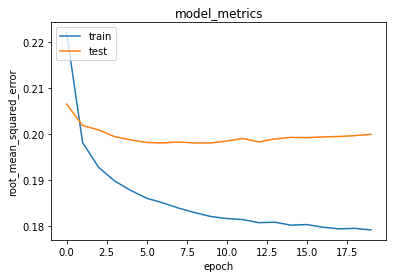

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Tahapan selanjutanya kita buat variable untuk menampung daftar movie yang sudah ditonton oleh user dan daftar movie yang belum ditonotn oleh user. Nah movie yang belum pernah ditonton itulah yang akan kita rekomendasikan kepada user.

In [ ]:
movie_df = movie_new
df = pd.read_csv('ml-latest-small/ratings.csv')

user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

Terakhir baru kita tampilkan rekomendasi movie untuk user.

In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.movie_genres)

print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_name, ':', row.movie_genres)

Showing recommendations for users: 459
Movie with high ratings from user
--------------------------------
Django Unchained (2012) : Action|Drama|Western
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
Incredibles, The (2004) : Action|Adventure|Animation|Children|Comedy
Avatar (2009) : Action|Adventure|Sci-Fi|IMAX
Doctor Strange (2016) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendation
--------------------------------
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Grand Day Out with Wallace and Gromit, A (1989) : Adventure|Animation|Children|Comedy|Sci-Fi
Once Upon a Time in the West (C'era una volta il West) (1968) : Action|Drama|Western
Godfather: Part II, The (1974) : Crime|Drama
Raging Bull (1980) : Drama
Third Man, The (1949) : Film-Noir|Mystery|Thriller
Ran (1985) : Drama|War
Lawrence of Arabia (1962) : Adventure|Drama|War
Paths of Glory (1957) : Drama|War
